# Sport instalation analysis

Variables:
- age	Age of the participants in years
- sex	Sex (0-female, 1-male)
- dayswfreq	Non-attendance days before dropout
- tbilled	Total amount billed in euros during the registration period (values in euros). 
- maccess	Average number of visits per week
- freeuse	Free use (0-no, 1-yes)
- nentries	Total number of visits to the fitness center that the customer made during the registration 
- cfreq	Weekly contracted accesses 
- nrenewals	Number of registration renewals
- cref	Number of customer referrals
- rmonth	Registration month
- months	Customer enrolment (total time in months)
- dropout	Measure of customers’ commitment (0=active, 1=dropout)


1/TRUE = dead i.e. abandonou
0/FALSE = alive i.e. não abandonou


Corrections to the analysis considering the reviewers suggestions:
1. Include 95% confidence intervals in Table 2 for the AUC
2. Before moving to decision tree models, one should always try standard logistic regression
3. There needs to be some cross validation performed. The reviewer suggests performing a three-fold cross validation for at least 50 iterations. This will generate condence intervals that the authors can see how stable their models are
4. Data stratification on the hold-out

# Support functions

In [9]:
# Adapted from https://gist.github.com/doraneko94/e24643136cfb8baf03ef8a314ab9615c
from sklearn.metrics import roc_auc_score
from math import sqrt
def roc_auc_ci(y_true, y_score, positive=1):
    '''
    # y_true = TRUE data
    # y_pred = predicted data at the model
    '''
    auc = roc_auc_score(y_true, y_score)
    n1 = sum(y_true == positive)
    n2 = sum(y_true != positive)
    q1 = auc / (2 - auc)
    q2 = 2*auc**2 / (1 + auc)
    se_auc = sqrt((auc*(1 - auc) + (n1 - 1)*(q1 - auc**2) + (n2 - 1)*(q2 - auc**2)) / (n1*n2))
    lower = auc - 1.96*se_auc
    upper = auc + 1.96*se_auc
    if lower < 0:
        lower = 0
    if upper > 1:
        upper = 1
    return (lower, upper)

# Imports

In [10]:
import numpy as np
import pandas as pd
import time
from sklearn import linear_model, datasets
from sklearn import metrics
from sklearn import preprocessing

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [12]:
# Disable warnings
import warnings
warnings.filterwarnings('ignore')

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,mean_squared_error
import time

import graphviz
import pydotplus
#import pydot
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
from IPython.display import Image  

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,mean_squared_error
from sklearn import metrics
import time

import graphviz
import pydotplus
#import pydot
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
from IPython.display import Image  

In [15]:
from sklearn.model_selection import GridSearchCV

In [16]:
from sklearn import tree
from dtreeviz.trees import *

In [17]:
%matplotlib inline

# Data processing

In [21]:
#reading data
dt = pd.read_excel('dataset/fitnessCustomers.xlsx',index_col=0)

In [22]:
#rows and columns
dt.shape

(5216, 13)

In [23]:
#feature names
dt.columns

Index(['age', 'sex', 'dayswfreq', 'tbilled', 'maccess', 'freeuse', 'nentries',
       'cfreq', 'nrenewals', 'cref', 'startDate', 'months', 'dropout'],
      dtype='object')

In [24]:
dt.head(2).T

Id,00130FE8-5D34-4C66-9819-1EB0BFE69979,0016D0DD-E713-4EDC-BAA3-386AB4CE6779
age,23,34
sex,1,1
dayswfreq,7,328
tbilled,37.6,205.6
maccess,1.35,0.54
freeuse,0,0
nentries,6,39
cfreq,7,7
nrenewals,0,2
cref,0,0


In [25]:
# number Customers by dropout
dt.dropout.value_counts()

1    4566
0     650
Name: dropout, dtype: int64

In [26]:
dt.head().T

Id,00130FE8-5D34-4C66-9819-1EB0BFE69979,0016D0DD-E713-4EDC-BAA3-386AB4CE6779,001A70CA-0985-42D1-A0C0-6D70BEC00BFB,001B9AC2-7711-4384-BF9D-C5205F68BDFC,001D927E-ACD2-4B3D-ACDA-1480F6A31F3E
age,23,34,24,20,21
sex,1,1,0,1,1
dayswfreq,7,328,3,41,18
tbilled,37.6,205.6,140,71.6,113.2
maccess,1.35,0.54,0.8,1,0.08
freeuse,0,0,0,0,0
nentries,6,39,28,13,7
cfreq,7,7,7,7,7
nrenewals,0,2,0,0,3
cref,0,0,0,0,0


## Inscription month calculation

In [27]:
# Calculate inscriptio month
dt['rmonth']=dt['startDate'].str.extract('-(\d\d)', expand=True)
dt['rmonth']=pd.to_numeric(dt['rmonth'])

In [28]:
# drop start date
dt.drop(axis=1,columns=['startDate'],inplace=True)

In [29]:
dt.columns

Index(['age', 'sex', 'dayswfreq', 'tbilled', 'maccess', 'freeuse', 'nentries',
       'cfreq', 'nrenewals', 'cref', 'months', 'dropout', 'rmonth'],
      dtype='object')

In [30]:
dt.head(2).T

Id,00130FE8-5D34-4C66-9819-1EB0BFE69979,0016D0DD-E713-4EDC-BAA3-386AB4CE6779
age,23.00,34.00
sex,1.00,1.00
dayswfreq,7.00,328.00
tbilled,37.60,205.60
maccess,1.35,0.54
freeuse,0.00,0.00
nentries,6.00,39.00
cfreq,7.00,7.00
nrenewals,0.00,2.00
cref,0.00,0.00


## Checking null values

In [31]:
dt.isnull().any()

age          False
sex          False
dayswfreq    False
tbilled      False
maccess      False
freeuse      False
nentries     False
cfreq         True
nrenewals    False
cref         False
months       False
dropout      False
rmonth       False
dtype: bool

In [32]:
dt.cfreq.value_counts()

7.0    5008
4.0     125
2.0      67
6.0      10
Name: cfreq, dtype: int64

In [33]:
# where are the nulls?
dt[pd.isnull(dt['cfreq'])]

,age,sex,dayswfreq,tbilled,maccess,freeuse,nentries,cfreq,nrenewals,cref,months,dropout,rmonth
Id,,,,,,,,,,,,,
4CA4608D-9366-46C7-9B51-7916E516B691,26,0,22,58.6,0.70,0,3,NaN,0,0,1,0,10
649D78E8-4C98-4397-AEDF-C6959AD959EA,26,0,6,126.1,0.03,0,3,NaN,2,0,25,0,10
6ABEE4C8-951A-4FE1-BF90-AAD1875AD582,21,0,8,58.6,1.63,0,7,NaN,0,0,1,0,10
A7438DA1-1801-4E73-8B99-896CC347C8FC,18,0,5,58.6,3.25,0,13,NaN,0,0,1,0,10
AEEDCE35-83DC-4CCB-A81F-5912FB6FE5C6,20,0,4,58.6,3.03,0,13,NaN,0,0,1,0,10
DE419BDD-A882-4754-8AA5-6656AF1D37CE,20,1,1,106.1,3.67,0,22,NaN,0,0,2,0,9


In [34]:
# How many values are nulls?
dt['cfreq'][pd.isnull(dt['cfreq'])].shape

(6,)

In [35]:
dt.shape

(5216, 13)

In [36]:
dt.dropna(axis=0,inplace=True)

In [37]:
dt.shape

(5210, 13)

### Drop freeuse column
The software used is also used to manage other sport facilities, such as swimming pools. In this study e only used customers that only perform fitness activities.The free use represents customers that in the past performed free use, which means that used to develop free swimming without a coach supervising their activity. That variable shouldn’t be in the study, and therefore we removed it.

In [38]:
dt.drop(axis=1,columns=['freeuse'],inplace=True)

## Descriptives

In [39]:
dt.describe().T

,count,mean,std,min,25%,50%,75%,max
age,5210.0,27.881766,11.804636,0.00,21.0000,23.00,30.00,93.00
sex,5210.0,0.351823,0.477585,0.00,0.0000,0.00,1.00,1.00
dayswfreq,5210.0,76.406526,101.792781,0.00,10.0000,41.00,99.00,991.00
tbilled,5210.0,155.314637,162.435028,3.60,61.6000,102.60,186.10,3747.20
maccess,5210.0,0.890616,0.761275,0.01,0.3325,0.68,1.21,10.33
nentries,5210.0,29.062188,41.149181,1.00,6.0000,15.00,34.75,585.00
cfreq,5210.0,6.861804,0.721352,2.00,7.0000,7.00,7.00,7.00
nrenewals,5210.0,0.777351,0.900260,0.00,0.0000,1.00,1.00,4.00
cref,5210.0,0.005566,0.076943,0.00,0.0000,0.00,0.00,2.00
months,5210.0,9.350288,8.215163,0.00,3.0000,7.00,12.00,47.00


### Checking Min age = 0
There is something not well, minimum age of 0

In [40]:
dt.loc[dt.age<10].T

Id,352A9804-29B4-49CA-BDF1-EEC6453F38D5,5AE0C2F9-35F0-4EB4-AE2F-F7398E3C75BF
age,9.00,0.0
sex,0.00,0.0
dayswfreq,204.00,118.0
tbilled,229.40,121.1
maccess,0.34,0.9
nentries,14.00,23.0
cfreq,4.00,7.0
nrenewals,1.00,1.0
cref,0.00,0.0
months,10.00,7.0


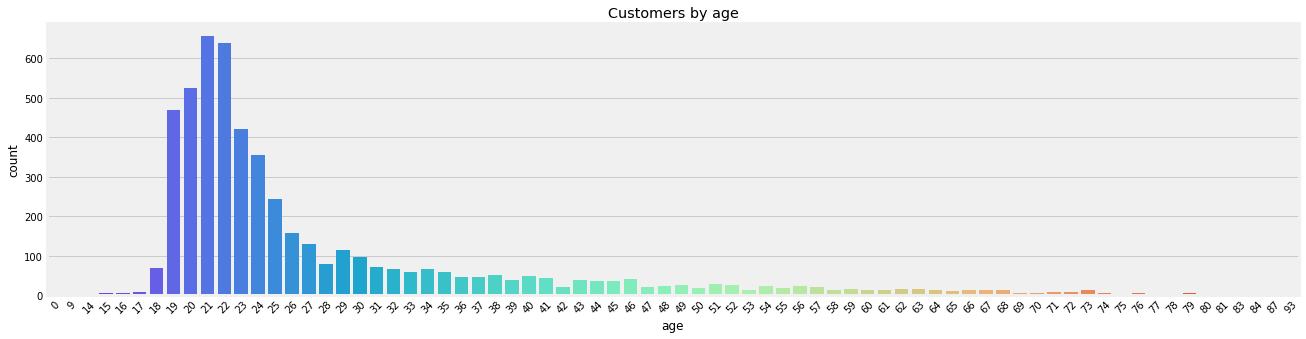

In [41]:
plt.rcParams['figure.figsize'] = [20, 5]
sns.countplot(x='age',data=dt,palette='rainbow').set_title('Customers by age')
plt.xticks(rotation=45);

### Remove the customer with age = 0

In [42]:
dt=dt.loc[dt.age!=0]

In [43]:
dt['sex'].value_counts()

0    3376
1    1833
Name: sex, dtype: int64

## Checking dataset balancing

In [44]:
class_dropout=dt.dropout.value_counts()
class_dropout

1    4565
0     644
Name: dropout, dtype: int64

In [45]:
# checking classes 
# dropout customer
print('Minority class represents %2f' %(class_dropout[0]/(class_dropout[0]+class_dropout[1])*100))

Minority class represents 12.363218


The minority class represents 12.46% of the data. We are in the presence of imbalanced dataset customers that didn't dropout. We are going to address this using grid search to tune this parameter Based on this example: https://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html#sphx-glr-auto-examples-model-selection-plot-multi-metric-evaluation-py

## Overall histograms

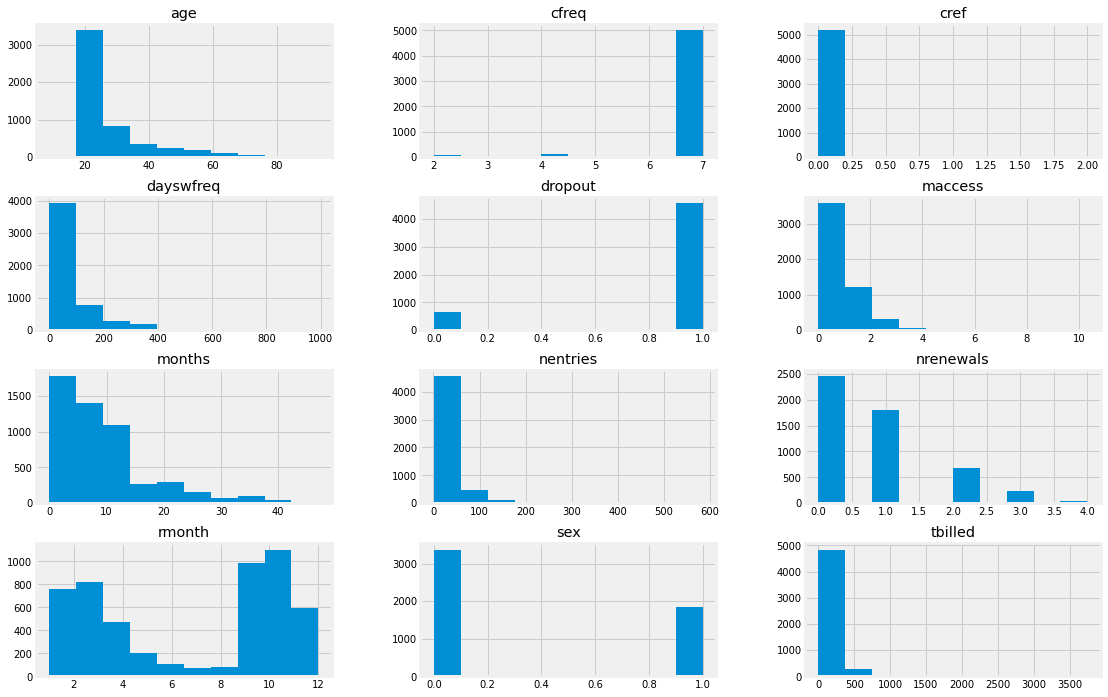

In [46]:
plt.rcParams['figure.figsize']=[17,12]
dt.hist();

# Dropout prediction

1. Some data preparation
2. Create dataset with features and prediction variable

In [47]:
X=dt.copy()
y=dt['dropout']
X.drop(axis=1,columns=['dropout'],inplace=True)

In [48]:
X.columns

Index(['age', 'sex', 'dayswfreq', 'tbilled', 'maccess', 'nentries', 'cfreq',
       'nrenewals', 'cref', 'months', 'rmonth'],
      dtype='object')

In [49]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5209 entries, 00130FE8-5D34-4C66-9819-1EB0BFE69979 to FFFB7214-F2FE-4AC0-8BD2-DB1CD47BDBEF
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        5209 non-null   int64  
 1   sex        5209 non-null   int64  
 2   dayswfreq  5209 non-null   int64  
 3   tbilled    5209 non-null   float64
 4   maccess    5209 non-null   float64
 5   nentries   5209 non-null   int64  
 6   cfreq      5209 non-null   float64
 7   nrenewals  5209 non-null   int64  
 8   cref       5209 non-null   int64  
 9   months     5209 non-null   int64  
 10  rmonth     5209 non-null   int64  
dtypes: float64(3), int64(8)
memory usage: 488.3+ KB


In [50]:
X.columns

Index(['age', 'sex', 'dayswfreq', 'tbilled', 'maccess', 'nentries', 'cfreq',
       'nrenewals', 'cref', 'months', 'rmonth'],
      dtype='object')

In [51]:
X.describe().round(decimals=2)

,age,sex,dayswfreq,tbilled,maccess,nentries,cfreq,nrenewals,cref,months,rmonth
count,5209.00,5209.00,5209.0,5209.00,5209.00,5209.00,5209.00,5209.00,5209.00,5209.00,5209.00
mean,27.89,0.35,76.4,155.32,0.89,29.06,6.86,0.78,0.01,9.35,6.72
std,11.80,0.48,101.8,162.45,0.76,41.15,0.72,0.90,0.08,8.22,3.53
min,9.00,0.00,0.0,3.60,0.01,1.00,2.00,0.00,0.00,0.00,1.00
25%,21.00,0.00,10.0,61.60,0.33,6.00,7.00,0.00,0.00,3.00,3.00
50%,23.00,0.00,41.0,102.60,0.68,15.00,7.00,1.00,0.00,7.00,9.00
75%,30.00,1.00,99.0,186.10,1.21,35.00,7.00,1.00,0.00,12.00,10.00
max,93.00,1.00,991.0,3747.20,10.33,585.00,7.00,4.00,2.00,47.00,12.00


In [52]:
y.describe().round(decimals=2)

count    5209.00
mean        0.88
std         0.33
min         0.00
25%         1.00
50%         1.00
75%         1.00
max         1.00
Name: dropout, dtype: float64

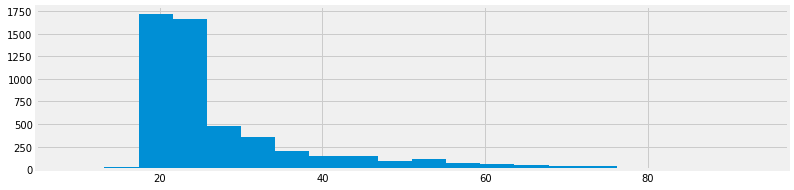

In [53]:
plt.rcParams['figure.figsize'] = [12, 3]
X.age.hist(bins=20)

In [54]:
X.sex.value_counts()

0    3376
1    1833
Name: sex, dtype: int64

## Comparison of the performance of the machine learning classifier

__Create train/test__
1. Following the proportion 2/3 for training and 1/3 for test (Kohavi 1995;Gama et al. 2017)
2. To ensure the proportion of cases in the train/test the stratification was defined in the target variable
3. Altought the class weights were optimized with grid-search best results were achieved with balanced.

Balanced calculations are based in the following formula:

$K_n=\frac{n}{k.n_j}$
where:
- $n$ sample size
- $k$ number of classes
- $n_j$ observations in class j

More details available in scikit-learn [docs](https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html
).

12% of the data are customers that didn't dropout. We are going to address this using grid search to tune this parameter Based on this example: https://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html#sphx-glr-auto-examples-model-selection-plot-multi-metric-evaluation-py

In [72]:
# calculation class weights
n=len(y)
k=2
print(y.value_counts())
n0=np.bincount(y)[0]
n1=np.bincount(y)[1]
print('class 1 %2f class 2 %2f' % ((n/(2*n0)),(n/(k*n1))))

1    4565
0     644
Name: dropout, dtype: int64
class 1 4.044255 class 2 0.570537


In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=2/3, stratify = y, random_state=0)
print('Size X_train:',X_train.shape)
print('Size X_test:',X_test.shape)
print('Size y_train:',y_train.shape)
print('Size y_test:',y_test.shape)

Size X_train: (3472, 11)
Size X_test: (1737, 11)
Size y_train: (3472,)
Size y_test: (1737,)


### Confirm if the proportion of cases are maintained

In [45]:
print('base \t%s ratio %2f \ny_train %s ratio %2f \ny_test \t%s ratio %2f'
      % (np.bincount(y), np.bincount(y)[0]/(np.bincount(y)[0]+np.bincount(y)[1]),
         np.bincount(y_train),np.bincount(y)[0]/(np.bincount(y)[0]+np.bincount(y)[1]),
         np.bincount(y_test), np.bincount(y)[0]/(np.bincount(y)[0]+np.bincount(y)[1])))

base 	[ 644 4565] ratio 0.123632 
y_train [ 429 3043] ratio 0.123632 
y_test 	[ 215 1522] ratio 0.123632


### Model accuracies

#### Logistic Regression

In [46]:
# getting params that can be optimized in gridsearch
LogisticRegression().get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [47]:
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l1', 'l2', 'elasticnet', 'none']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)

In [48]:
start_time = time.time()

scoring = {'AUC': 'roc_auc'}
gs = GridSearchCV(estimator = LogisticRegression(random_state=42, class_weight={0: 4.0, 1: 0.571}),
                  param_grid=grid,
                  scoring=scoring, 
                  refit='AUC', 
                  return_train_score=True)
grid_result = gs.fit(X_train,y_train)
print('best params',grid_result.best_params_)
print('best AUC score:',grid_result.best_score_)
print('execution time:',time.time()-start_time)

best params {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
best AUC score: 0.8417935009968195
execution time: 143.2659125328064


In [49]:
model_LR = LogisticRegression(C=1.0,penalty='l2', solver='liblinear' , random_state=42, class_weight={0: 4.0, 1: 0.571})
model_LR.fit(X_train,y_train)
y_pred_lr = model_LR.predict(X_test)
print(metrics.classification_report(y_test,y_pred_lr))
print(metrics.confusion_matrix(y_test,y_pred_lr))
#print("Features sorted by their score:") Logistic regression dont allow to sort features by their score
#print(sorted(zip(map(lambda x: float("{0:.2f}".format(round(x, 4))), model.feature_importances_), X_train.columns),reverse=True))
matrix_LR=metrics.confusion_matrix(y_test, y_pred_lr)
print('AUC',metrics.roc_auc_score(y_test, y_pred_lr))
print('AUC_ROC',roc_auc_ci(y_test,y_pred_lr))

              precision    recall  f1-score   support

           0       0.34      0.79      0.48       215
           1       0.96      0.79      0.87      1522

    accuracy                           0.79      1737
   macro avg       0.65      0.79      0.67      1737
weighted avg       0.89      0.79      0.82      1737

[[ 169   46]
 [ 327 1195]]
AUC 0.7855988142896433
AUC_ROC (0.7587821295307224, 0.8124154990485641)


$ \begin{align} sensivity = \frac{TP}{TP+FN} \end{align} $
$ \begin{align} specificity = \frac{TN}{TN+FP} \end{align} $
$ \begin{align} precision = \frac{TP}{TP+FP} \end{align} $
$ \begin{align} F-Score = \frac{2xTP}{2xTP+FP+FN} \end{align} $

**Logistic regression**

|  &nbsp; | &nbsp; |real<br/>pos|<br/>neg |
|---------|--------|:----------:|--------:|
|Pre      | Pos    |     169    |     46  |
|  &nbsp; | Neg    |     327    |    1195 |

- Sensitity = TP/(TP+FN) = 169/(169+327) = 0.34 <br/>
- Specificity = TN/(TN+FP) = 1195/(1195+46) = 0.96 <br/>
- Precision = TP / (TP+FP) = 169/(169+46) = 0.79 <br/>
- F1Score = 2TP/(2TP+FP+FN) = 2x169/(2x169+46+327) = 0.47

In [50]:
print('sensitivity %f, specificity %f, precision %f, f1score %f' %((169/(169+327)),1195/(1195+46),169/(169+46),2*169/(2*169+46+327)))

sensitivity 0.340726, specificity 0.962933, precision 0.786047, f1score 0.475387


#### DecisionTreeClassifier

In [51]:
DecisionTreeClassifier().get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': None,
 'splitter': 'best'}

In [52]:
max_features = ['auto', 'sqrt', 'log2','None']
max_depth = [3,4,5,6,7,8]
criterion = ['gini', 'entropy']
class_weight = ["balanced", "balanced_subsample"]

# define grid search
grid = dict(max_features=max_features,max_depth=max_depth, criterion=criterion, class_weight = class_weight)

In [53]:
start_time = time.time()

scoring = {'AUC': 'roc_auc'}
gs = GridSearchCV(estimator = DecisionTreeClassifier(random_state=42),
                  param_grid=grid,
                  scoring=scoring, 
                  refit='AUC', 
                  return_train_score=True)
grid_result = gs.fit(X_train,y_train)
print('best params',grid_result.best_params_)
print('best AUC score:',grid_result.best_score_)
print('execution time:',time.time()-start_time)

best params {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5, 'max_features': 'auto'}
best AUC score: 0.8905878914421885
execution time: 1.8378710746765137


Class balanced is calculated using this formula $K_n=\frac{n}{k.n_j}$ so we mantain class_weight={0: 4.0, 1: 0.571}

In [55]:
model_DTC = DecisionTreeClassifier(class_weight={0: 4.0, 1: 0.571}, criterion='entropy',max_depth = 5, max_features='auto', random_state=42)
model_DTC.fit(X_train,y_train)
y_pred_dtc = model_DTC.predict(X_test)
print(metrics.classification_report(y_test,y_pred_dtc))
print(metrics.confusion_matrix(y_test,y_pred_dtc))
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: float("{0:.2f}".format(round(x, 4))), model_DTC.feature_importances_), X_train.columns),reverse=True))
matrix_DTC=metrics.confusion_matrix(y_test, y_pred_dtc)
print('AUCROC:',metrics.roc_auc_score(y_test, y_pred_dtc))
print('AUC_ROC_CI',roc_auc_ci(y_test,y_pred_dtc))

              precision    recall  f1-score   support

           0       0.51      0.80      0.62       215
           1       0.97      0.89      0.93      1522

    accuracy                           0.88      1737
   macro avg       0.74      0.85      0.78      1737
weighted avg       0.91      0.88      0.89      1737

[[ 173   42]
 [ 166 1356]]
Features sorted by their score:
[(0.55, 'dayswfreq'), (0.16, 'tbilled'), (0.13, 'months'), (0.08, 'nrenewals'), (0.02, 'rmonth'), (0.02, 'age'), (0.01, 'nentries'), (0.01, 'maccess'), (0.0, 'sex'), (0.0, 'cref'), (0.0, 'cfreq')]
AUCROC: 0.847792072853956
AUC_ROC_CI (0.8264697551172449, 0.8691143905906671)


$ \begin{align} sensivity = \frac{TP}{TP+FN} \end{align} $
$ \begin{align} specificity = \frac{TN}{TN+FP} \end{align} $
$ \begin{align} precision = \frac{TP}{TP+FP} \end{align} $
$ \begin{align} F-Score = \frac{2xTP}{2xTP+FP+FN} \end{align} $

**Decision Tree Classifier**


|  &nbsp; | &nbsp; |real<br/>pos|<br/>neg |
|---------|--------|:----------:|--------:|
|Pre      | Pos    |     173    |     42  |
|  &nbsp; | Neg    |     166    |    1356 |

- Sensivity = TP/(TP+FN) = 173/(173+166) = 0.51 <br/>
- Specificity = TN/(TN+FP) = 1356/(1356+42) = 0.970 <br/>
- Precision = TP / (TP+FP) = 173/(173+42) = 0.805 <br/>
- F1Score = 2TP/(2TP+FP+FN) = 2x173/(2x173+42+166) = 0.625

In [56]:
print('sensitivy %f, specificity %f, precision %f, f1score %f' %((173/(173+166)),1356/(1356+42),173/(173+42), 2*173/(2*173+42+166)))

sensitivy 0.510324, specificity 0.969957, precision 0.804651, f1score 0.624549


#### Random Forest Classifier

In [57]:
RandomForestClassifier().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [58]:
n_estimators = [100,200, 500]
max_features = ['auto', 'sqrt', 'log2','None']
max_depth = [4,5,6,7,8]
criterion = ['gini', 'entropy']
class_weight = ["balanced", "balanced_subsample"]

# define grid search
grid = dict(n_estimators = n_estimators,max_features=max_features,max_depth=max_depth, criterion=criterion, class_weight = class_weight)

In [59]:
start_time = time.time()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=2/3, stratify = y, random_state=0)

scoring = {'AUC': 'roc_auc'}
gs = GridSearchCV(estimator = RandomForestClassifier(random_state=42),
                  param_grid=grid,
                  scoring=scoring, 
                  refit='AUC', 
                  return_train_score=True)
grid_result = gs.fit(X_train,y_train)
print('best params',grid_result.best_params_)
print('best AUC score:',grid_result.best_score_)
print('execution time:',time.time()-start_time)

best params {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 500}
best AUC score: 0.9517397641853348
execution time: 696.2199819087982


In [61]:
model_RFC = RandomForestClassifier(class_weight='balanced',criterion='gini',max_depth=8,max_features='auto',
                                   n_estimators=500, random_state=42)
model_RFC.fit(X_train,y_train)
y_pred_rfc = model_RFC.predict(X_test)
print(metrics.classification_report(y_test,y_pred_rfc))
print(metrics.confusion_matrix(y_test,y_pred_rfc))
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: float("{0:.2f}".format(round(x, 4))), model_RFC.feature_importances_), X_train.columns),reverse=True))
matrix_RFC=metrics.confusion_matrix(y_test, y_pred_rfc)
print('AUC',metrics.roc_auc_score(y_test, y_pred_rfc))
print('AUCROC:',metrics.roc_auc_score(y_test, y_pred_rfc))
print('AUC_ROC_CI',roc_auc_ci(y_test,y_pred_rfc))

              precision    recall  f1-score   support

           0       0.65      0.79      0.71       215
           1       0.97      0.94      0.95      1522

    accuracy                           0.92      1737
   macro avg       0.81      0.86      0.83      1737
weighted avg       0.93      0.92      0.92      1737

[[ 170   45]
 [  93 1429]]
Features sorted by their score:
[(0.43, 'dayswfreq'), (0.14, 'months'), (0.1, 'tbilled'), (0.08, 'maccess'), (0.07, 'age'), (0.06, 'rmonth'), (0.06, 'nentries'), (0.05, 'nrenewals'), (0.01, 'sex'), (0.01, 'cfreq'), (0.0, 'cref')]
AUC 0.8647969318216544
AUCROC: 0.8647969318216544
AUC_ROC_CI (0.8451435573967021, 0.8844503062466067)


$ \begin{align} sensivity = \frac{TP}{TP+FN} \end{align} $ 
$ \begin{align} specificity = \frac{TN}{TN+FP} \end{align} $
$ \begin{align} precision = \frac{TP}{TP+FP} \end{align} $
$ \begin{align} F-Score = \frac{2xTP}{2xTP+FP+FN} \end{align} $

**Random Forest Classifier**

|  &nbsp; | &nbsp; |real<br/>pos|<br/>neg |
|---------|--------|:----------:|--------:|
|Pre      | Pos    |     170    |     45  |
|  &nbsp; | Neg    |      93    |    1429 |

- Sensivity = TP/(TP+FN) = 170/(170+93) = 0.647 <br/>
- Specificity = TN/(TN+FP) = 1429/(1429+45) = 0.969 <br/>
- Precision = TP / (TP+FP) = 170/(170+45) = 0.790 <br/>
- F1Score = 2TP/(2TP+FP+FN) = 2x170/(2x170+45+93) = 0.711

In [63]:
print('sensitivy %f, specificity %f, precision %f, f1score %f' %(170/(170+93),1429/(1429+45),170/(170+45), 2*170/(2*170+45+93)))

sensitivy 0.646388, specificity 0.969471, precision 0.790698, f1score 0.711297


#### Gradient Boosting Classifier

In [64]:
GradientBoostingClassifier().get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'presort': 'deprecated',
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [65]:
n_estimators = [100, 200, 500]
max_features = ['auto', 'sqrt', 'log2','None']
max_depth = [3,4,5,6,7,8]

# define grid search
grid = dict(n_estimators = n_estimators,max_features=max_features,max_depth=max_depth)

In [66]:
start_time = time.time()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=2/3, stratify = y, random_state=0)

scoring = {'AUC': 'roc_auc'}
gs = GridSearchCV(estimator = GradientBoostingClassifier(random_state=42),
                  param_grid=grid,
                  scoring=scoring, 
                  refit='AUC', 
                  return_train_score=True)
grid_result = gs.fit(X_train,y_train)
print('best params',grid_result.best_params_)
print('best AUC score:',grid_result.best_score_)
print('execution time:',time.time()-start_time)

best params {'max_depth': 6, 'max_features': 'sqrt', 'n_estimators': 500}
best AUC score: 0.965127764396604
execution time: 248.593403339386


In [67]:
model_gbc = GradientBoostingClassifier(max_depth=6,max_features='sqrt',n_estimators=500, random_state=42)
model_gbc.fit(X_train,y_train)
y_pred_gbc = model_gbc.predict(X_test)
print(metrics.classification_report(y_test,y_pred_gbc))
print(metrics.confusion_matrix(y_test,y_pred_gbc))
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: float("{0:.2f}".format(round(x, 4))), model_gbc.feature_importances_), X_train.columns),reverse=True))
matrix_GBC=metrics.confusion_matrix(y_test, y_pred_gbc)
print('AUCROC:',metrics.roc_auc_score(y_test, y_pred_gbc))
print('AUC_ROC_CI',roc_auc_ci(y_test,y_pred_gbc))

              precision    recall  f1-score   support

           0       0.88      0.73      0.80       215
           1       0.96      0.99      0.97      1522

    accuracy                           0.96      1737
   macro avg       0.92      0.86      0.89      1737
weighted avg       0.95      0.96      0.95      1737

[[ 158   57]
 [  21 1501]]
Features sorted by their score:
[(0.35, 'dayswfreq'), (0.15, 'months'), (0.14, 'tbilled'), (0.07, 'rmonth'), (0.07, 'nentries'), (0.07, 'maccess'), (0.07, 'age'), (0.06, 'nrenewals'), (0.01, 'sex'), (0.01, 'cfreq'), (0.0, 'cref')]
AUCROC: 0.8605430431195183
AUC_ROC_CI (0.8404650542744497, 0.880621031964587)


$ \begin{align} sensivity = \frac{TP}{TP+FN} \end{align} $ 
$ \begin{align} specificity = \frac{TN}{TN+FP} \end{align} $
$ \begin{align} precision = \frac{TP}{TP+FP} \end{align} $
$ \begin{align} F-Score = \frac{2xTP}{2xTP+FP+FN} \end{align} $

**Gradient Boosting Classifier**

|  &nbsp; | &nbsp; |real<br/>pos|<br/>neg |
|---------|--------|:----------:|--------:|
|Pre      | Pos    |     158    |      57 |
|  &nbsp; | Neg    |      21    |    1501 |

- Sensivity = TP/(TP+FN) = 158/(158+21) = 0.887 <br/>
- Specificity = TN/(TN+FP) = 1501/(1501+57) = 0.968 <br/>
- Precision = TP / (TP+FP) = 158/(158+57) = 0.760 <br/>
- F1Score = 2TP/(2TP+FP+FN) = 2x158/(2x158+57+21) = 0.8

In [69]:
print('sensitivy %f, specificity %f, precision %f, f1score %f' %(158/(158+21),1501/(1501+57),158/(158+57), 2*158/(2*158+57+21)))

sensitivy 0.882682, specificity 0.963415, precision 0.734884, f1score 0.802030


## Variable importance

Logistic Regression doesn't have feature importance. We are working in a classification problem with classes 0 and 1. The coefficients are  positive and negative, the positive represents a feature that predicts class 1,the negative scores a feature that predicts class 0.

In [83]:
X_test.columns

Index(['age', 'sex', 'dayswfreq', 'tbilled', 'maccess', 'nentries', 'cfreq',
       'nrenewals', 'cref', 'months', 'rmonth'],
      dtype='object')

In [82]:
pd.DataFrame(list(zip(model_DTC.feature_importances_,X_test.columns)))

,0,1
0,0.019923,age
1,0.002618,sex
2,0.553739,dayswfreq
3,0.163024,tbilled
4,0.008315,maccess
5,0.010938,nentries
6,0.001052,cfreq
7,0.084032,nrenewals
8,0.000000,cref
9,0.134492,months


In [84]:
pd.DataFrame(list(zip(model_RFC.feature_importances_,X_test.columns)))

,0,1
0,0.065540,age
1,0.006523,sex
2,0.432990,dayswfreq
3,0.097895,tbilled
4,0.084736,maccess
5,0.058316,nentries
6,0.005794,cfreq
7,0.046346,nrenewals
8,0.000296,cref
9,0.142693,months


In [89]:
pd.DataFrame(list(zip(model_gbc.feature_importances_,X_test.columns)))

,0,1
0,0.073031,age
1,0.008865,sex
2,0.350187,dayswfreq
3,0.144715,tbilled
4,0.071915,maccess
5,0.069500,nentries
6,0.011180,cfreq
7,0.055012,nrenewals
8,0.000565,cref
9,0.147133,months


In [90]:
importance = pd.DataFrame(dict(features=X_test.columns,lr=model_LR.coef_[0],
                               dtc=model_DTC.feature_importances_,
                               rfc=model_RFC.feature_importances_,
                               gbc=model_gbc.feature_importances_)).set_index('features')
importance=importance.sort_values(by='gbc',ascending=False)

In [91]:
importance

,lr,dtc,rfc,gbc
features,,,,
dayswfreq,0.004427,0.553739,0.432990,0.350187
months,-0.086537,0.134492,0.142693,0.147133
tbilled,-0.002418,0.163024,0.097895,0.144715
age,-0.031351,0.019923,0.065540,0.073031
maccess,-1.408999,0.008315,0.084736,0.071915
nentries,0.017364,0.010938,0.058316,0.069500
rmonth,-0.071246,0.021867,0.058872,0.067897
nrenewals,-0.399163,0.084032,0.046346,0.055012
cfreq,0.260549,0.001052,0.005794,0.011180


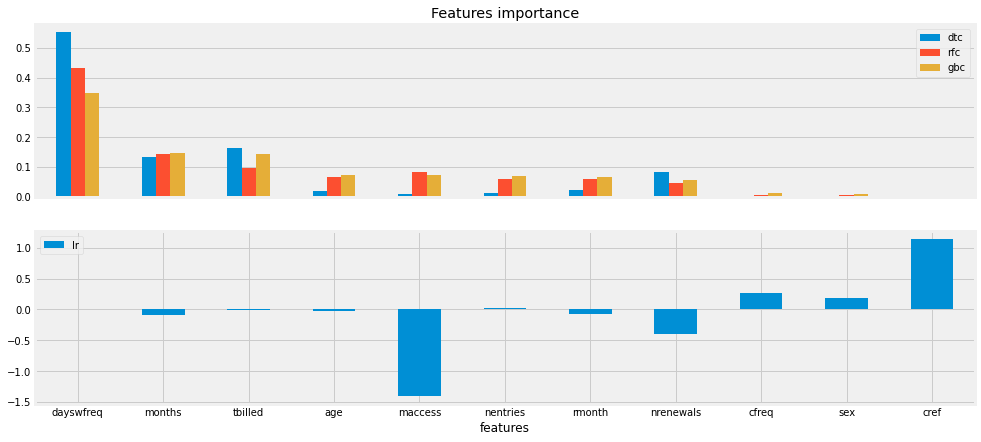

In [93]:
fig,ax = plt.subplots(2,1,figsize=(15,7))
ax1,ax2=ax.flatten()
ax1.set_xticks([])
ax2.set_xticks([])
#sns.distplot()
importance[['dtc','rfc','gbc']].plot(kind='bar',title='Features importance',ax=ax1,xticks=[]).xaxis.label.set_visible(False);
importance[['lr']].plot(kind='bar',ax=ax2);

## Old

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
print('Size X_train:',X_train.shape)
print('Size X_test:',X_test.shape)
print('Size y_train:',y_train.shape)
print('Size y_test:',y_test.shape)

names = []
scores = []

tInicial = time.time()
for name, model in models:
    t0 = time.time()
    # Colocar o tempo de execução de cada algoritmo t_inicio = 
    print(model)
    if name == 'DTC': model = DecisionTreeClassifier(max_depth = 3, random_state=42)
    if name == 'RFC': model = RandomForestClassifier(max_depth = 3, random_state=42)
    if name == 'GBC': model = GradientBoostingClassifier(max_depth = 3, random_state=42)
        
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(metrics.classification_report(y_test, y_pred))
    print(metrics.confusion_matrix(y_test, y_pred))
    print('RMSE:',metrics.mean_squared_error(y_test,y_pred))

    scores.append(accuracy_score(y_test, y_pred))
    names.append(name)
    
    t1 = time.time()
    total = t1-t0
    print('duracao:',total)
    print("Features sorted by their score:")
    print(sorted(zip(map(lambda x: float("{0:.2f}".format(round(x, 4))), model.feature_importances_), X_train.columns),reverse=True))
    if (name == 'DTC'):
        dot_data = StringIO()
        export_graphviz(model, out_file=dot_data, feature_names=X.columns, class_names=X.columns,
                        filled=False, rounded=True,
                        special_characters=True)
        graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
        graph.write_png('../graficos/'+name+'_arvore.png')
        Image(graph.create_png())
        matrix_DTC=metrics.confusion_matrix(y_test, y_pred)
        
    if (name == 'RFC'):
        dot_data = StringIO()
        for i in range(10):
            estimator = model.estimators_[i]
            dot_data = export_graphviz(estimator, out_file=None, feature_names=X.columns,class_names=X.columns,rounded=True)
            graph = pydotplus.graph_from_dot_data(dot_data)  
            graph.write_png('../graficos/'+name+str(i)+'_arvore.png')
            Image(graph.create_png())
            matrix_RFC=metrics.confusion_matrix(y_test, y_pred)
    if (name == 'GBC'):
        dot_data = StringIO()
        sub_tree_42 = model.estimators_[98, 0]
        export_graphviz(sub_tree_42, 
                        out_file=dot_data, 
                        feature_names=X.columns, class_names=X.columns,
                        filled=False, rounded=True,
                        special_characters=True)
        graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
        graph.write_png('../graficos/'+name+'_arvore.png')
        Image(graph.create_png())
        matrix_GBC=metrics.confusion_matrix(y_test, y_pred)
        
tr_split = pd.DataFrame({'Nome': names, 'Accuracy': scores})
print(tr_split)

tFinal = time.time()
total = tFinal-t0
print('duracao:',total)

Size X_train: (3912, 12)
Size X_test: (1304, 12)
Size y_train: (3912,)
Size y_test: (1304,)
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
              precision    recall  f1-score   support

           0       0.67      0.42      0.52       148
           1       0.93      0.97      0.95      1156

    accuracy                           0.91      1304
   macro avg       0.80      0.70      0.73      1304
weighted avg       0.90      0.91      0.90      1304

[[  62   86]
 [  30 1126]]
RMSE: 0.08895705521472393
duracao: 0.02898859977722168
Features sorted by their score:
[(0.8, 'dayswfreq'), (0.15, 'tbilled'), 

## Visualização com o dtreeviz

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
print('Size X_train:',X_train.shape)
print('Size X_test:',X_test.shape)
print('Size y_train:',y_train.shape)
print('Size y_test:',y_test.shape)

names = []
scores = []

tInicial = time.time()
for name, model in models:
    t0 = time.time()
    # Colocar o tempo de execução de cada algoritmo t_inicio = 
    print(model)
    if name == 'DTC':
        model = DecisionTreeClassifier(max_depth = 3, random_state=42)
    if name == 'RFC':
        model = RandomForestClassifier(max_depth = 3, random_state=42)
    if name == 'GBC':
        model = GradientBoostingClassifier(max_depth = 3, random_state=42)
        
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(metrics.classification_report(y_test, y_pred))
    print(metrics.confusion_matrix(y_test, y_pred))
    print('RMSE:',metrics.mean_squared_error(y_test,y_pred))

    scores.append(accuracy_score(y_test, y_pred))
    names.append(name)
    
    t1 = time.time()
    total = t1-t0
    print('duracao:',total)
    print("Features sorted by their score:")
    print(sorted(zip(map(lambda x: float("{0:.2f}".format(round(x, 4))), model.feature_importances_), X_train.columns),reverse=True))
    if (name == 'DTC'):
        viz = dtreeviz(model,X_train,y_train,target_name='dropout',
               feature_names=['age', 'gender', 'dayswfreq', 'months', 'tbilled', 'maccess',
                              'free_use', 'nactivities', 'nentries', 'cfreq', 'nrenewals', 'cref','rmonth'],class_names=['no','yes'])
              
        #viz.view()
        viz.save('../graficos/dtree_'+name+'_arvore.svg')
        
    if (name == 'RFC'):
        dot_data = StringIO()
        for i in range(10):
            estimator = model.estimators_[i]
            viz = dtreeviz(estimator,X_train,y_train,target_name='dropout',
                   feature_names=['age', 'gender', 'dayswfreq', 'months', 'tbilled', 'maccess',
                                  'free_use', 'nactivities', 'nentries', 'cfreq', 'nrenewals', 'cref','rmonth'],class_names=['no','yes'])

            #viz.view()
            viz.save('../graficos/dtree_'+name+str(i)+'_arvore.svg')
    if (name == 'GBC'):
        sub_tree_42 = model.estimators_[98, 0]
        viz = dtreeviz(sub_tree_42,X_train,y_train,target_name='dropout',
               feature_names=['age', 'gender', 'dayswfreq', 'months', 'tbilled', 'maccess',
                              'free_use', 'nactivities', 'nentries', 'cfreq', 'nrenewals', 'cref','rmonth'],class_names=['no','yes'])

        #viz.view()
        viz.save('../graficos/dtree_'+name+str(i)+'_arvore.svg')
        
tr_split = pd.DataFrame({'Nome': names, 'Accuracy': scores})
print(tr_split)

tFinal = time.time()
total = tFinal-t0
print('duracao:',total)

Size X_train: (3912, 12)
Size X_test: (1304, 12)
Size y_train: (3912,)
Size y_test: (1304,)
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
              precision    recall  f1-score   support

           0       0.67      0.42      0.52       148
           1       0.93      0.97      0.95      1156

    accuracy                           0.91      1304
   macro avg       0.80      0.70      0.73      1304
weighted avg       0.90      0.91      0.90      1304

[[  62   86]
 [  30 1126]]
RMSE: 0.08895705521472393
duracao: 0.02516317367553711
Features sorted by their score:
[(0.8, 'dayswfreq'), (0.15, 'tbilled'), 

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
model = DecisionTreeClassifier(max_depth = 3, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(metrics.classification_report(y_test, y_pred))
print(metrics.confusion_matrix(y_test, y_pred))
print('RMSE:',metrics.mean_squared_error(y_test,y_pred))


              precision    recall  f1-score   support

           0       0.67      0.42      0.52       148
           1       0.93      0.97      0.95      1156

    accuracy                           0.91      1304
   macro avg       0.80      0.70      0.73      1304
weighted avg       0.90      0.91      0.90      1304

[[  62   86]
 [  30 1126]]
RMSE: 0.08895705521472393


In [97]:
y_pred = model.predict(X_train)
np.round(metrics.roc_auc_score(y_train, y_pred),3)

0.719

In [99]:
roc_auc_ci(y_train,y_pred)

(0.6976607489608436, 0.7393922122149811)

**Métricas de avaliação do desempenho**

$ \begin{align} sensivity = \frac{TP}{TP+FN} \end{align} $
$ \begin{align} specificity = \frac{TN}{TN+FP} \end{align} $
$ \begin{align} precision = \frac{TP}{TP+FP} \end{align} $
$ \begin{align} F-Score = \frac{2xTP}{2xTP+FP+FN} \end{align} $

**Decision Tree Classifier**

|  &nbsp; | &nbsp; |real<br/>pos|<br/>neg |
|---------|--------|:----------:|--------:|
|Pre      | Pos    |     62     |     86  |
|  &nbsp; | Neg    |     30     |    1126 |

Sensitity = TP/(TP+FN) = 62/(62+30) = 0.674 <br/>
Specificity = TN/(TN+FP) = 1126/(1126+86) = 0.929 <br/>
Precision = TP / (TP+FP) = 62/(62+86) = 0.419 <br/>
F1Score = 2TP/(2TP+FP+FN) = 2x62/(2x62+86+30) =0.582

**Random Forest Classifier**

|  &nbsp; | &nbsp; |real<br/>pos|<br/>neg |
|---------|--------|:----------:|--------:|
|Pre      | Pos    |     35     |    113  |
|  &nbsp; | Neg    |      5     |    1151 |

Sensitity = TP/(TP+FN) = 35/(35+5) = 0.875 <br/>
Specificity = TN/(TN+FP) = 1151/(1151+113) = 0.911 <br/>
Precision = TP / (TP+FP) = 35/(35+113) = 0.236 <br/>
F1Score = 2TP/(2TP+FP+FN) = 2x35/(2x35+113+5) =0.372

**Gradient Boosting Classifier**

|  &nbsp; | &nbsp; |real<br/>pos|<br/>neg |
|---------|--------|:----------:|--------:|
|Pre      | Pos    |     101    |    47   |
|  &nbsp; | Neg    |     28     |    1128 |

Sensitity = TP/(TP+FN) = 101/(101+28) = 0.783 <br/>
Specificity = TN/(TN+FP) = 1128/(1128+47) = 0.960 <br/>
Precision = TP / (TP+FP) = 101/(101+47) = 0.682 <br/>
F1Score = 2TP/(2TP+FP+FN) = 2x101/(2x101+47+28) =0.729

In [56]:
matrix_GBC

array([[ 101,   47],
       [  28, 1128]])

In [57]:
matrix_RFC

array([[  30,  118],
       [   7, 1149]])

In [58]:
matrix_DTC

array([[  62,   86],
       [  30, 1126]])

## Model accuracy

In [59]:
plt.rcParams['figure.figsize'] = [12, 3]

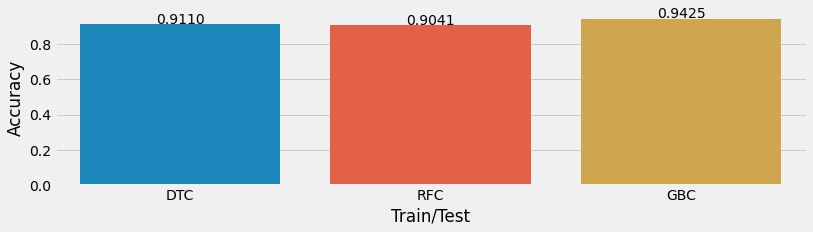

In [60]:
import seaborn as sns
axis = sns.barplot(x = 'Nome', y = 'Accuracy', data = tr_split)
axis.set(xlabel='Train/Test', ylabel='Accuracy')
for p in axis.patches:
    height = p.get_height()
    axis.text(p.get_x() + p.get_width()/2, height + 0.005, '{:1.4f}'.format(height), ha="center") 
    
plt.show()

In [61]:
import numpy as np
#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(model.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances = pd.DataFrame({'feature':X.columns})
for name, model in models:
    t0=time.time()
    score = accuracy_score(y_test, y_pred)
    model.fit(X,y) 
    names.append(name)
    scores.append(score)
    
    t1 = time.time()
    total = t1-t0
    importances[name] = np.round(model.feature_importances_,3)

importances = importances.set_index('feature')
importances

,DTC,RFC,GBC
feature,,,
age,0.071,0.087,0.047
sex,0.010,0.013,0.001
dayswfreq,0.332,0.277,0.528
months,0.118,0.139,0.138
tbilled,0.106,0.146,0.085
maccess,0.070,0.101,0.012
free_use,0.027,0.018,0.033
nentries,0.066,0.082,0.015
cfreq,0.014,0.016,0.022


## Variable importance

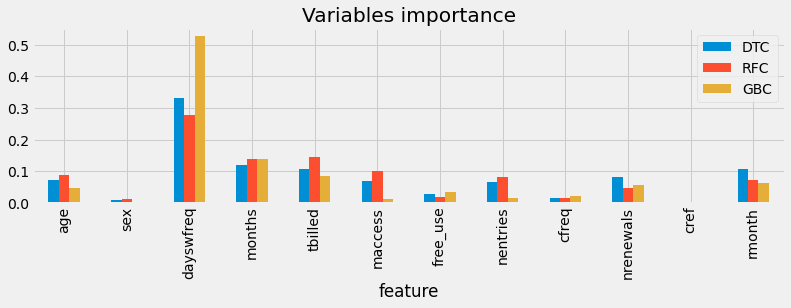

In [62]:
importances.plot(kind='bar',title='Variables importance')

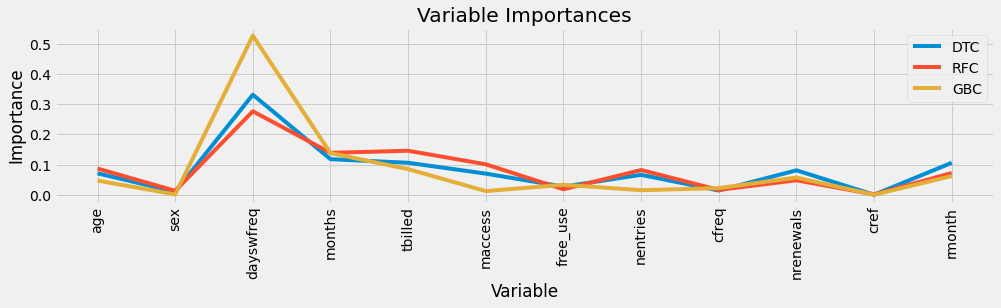

In [63]:
plt.rcParams['figure.figsize'] = [15, 3]

x_values = list(range(len(importances)))
# Make a bar chart
plt.plot(x_values, importances)
# Tick labels for x axis
plt.xticks(x_values, X_train.columns, rotation='vertical')
plt.legend(('DTC','RFC','GBC'))
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');


### ROC Curve
Receive Operating Characteristics Curve

In [135]:
    model = DecisionTreeClassifier(max_depth = 3, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[::,1]
    
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)
    auc =  np.round(metrics.roc_auc_score(y_test, y_pred_proba),4)
    auc_ic=roc_auc_ci(y_test,y_pred)
    print(name,auc,auc_ic)


GBC 0.86 (0.6568889466396829, 0.7360784151858105)


### Calculations

(0.8041193277474075, 0.8584636704757291)
(0.8064050143043162, 0.8602928254039042)
(0.801212058778947, 0.8561338684631742)


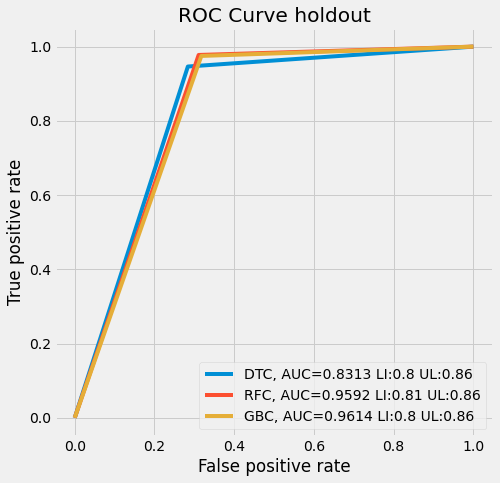

In [113]:
plt.rcParams['figure.figsize'] = [7, 7]

for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[::,1]
    
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)
    auc =  np.round(metrics.roc_auc_score(y_test, y_pred_proba),4)
    auc_ic=roc_auc_ci(y_test,y_pred)
    print(auc_ic)
    plt.plot(fpr,tpr,label=name + ", AUC="+str(auc)+' LI:'+str(np.round(auc_ic[0],2))+' UL:'+str(np.round(auc_ic[1],2)))
    plt.legend(loc=4)
    
plt.title('ROC Curve holdout')
plt.xlabel('False positive rate'); plt.ylabel('True positive rate')
plt.show()

## k-fold

In [65]:
#from sklearn.cross_validation import KFold
from sklearn.model_selection import KFold
names = []
scores = []

tInicio=time.time()
for name, model in models:
    t0=time.time()
    kfold = KFold(n_splits=10, random_state=10) 
    score = cross_val_score(model, X, y, cv=kfold, scoring='accuracy').mean()
    print(model)
    model.fit(X,y) 
    names.append(name)
    scores.append(score)
    
    t1 = time.time()
    total = t1-t0
    print('duracao:',total)
    print("Features sorted by their score:")
    print(sorted(zip(map(lambda x: float("{0:.2f}".format(round(x, 4))), model.feature_importances_), X_train.columns),reverse=True))
    
kf_cross_val = pd.DataFrame({'Name': names, 'Score': scores})
tFinal = time.time(); total = tFinal-tInicio; print(total)

print(kf_cross_val)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
duracao: 0.6683351993560791
Features sorted by their score:
[(0.34, 'dayswfreq'), (0.12, 'months'), (0.1, 'tbilled'), (0.1, 'rmonth'), (0.08, 'nrenewals'), (0.07, 'nentries'), (0.07, 'maccess'), (0.07, 'age'), (0.03, 'free_use'), (0.01, 'sex'), (0.01, 'cfreq'), (0.0, 'cref')]
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
        

## Model accuracy

In [66]:
plt.rcParams['figure.figsize'] = [12, 3]

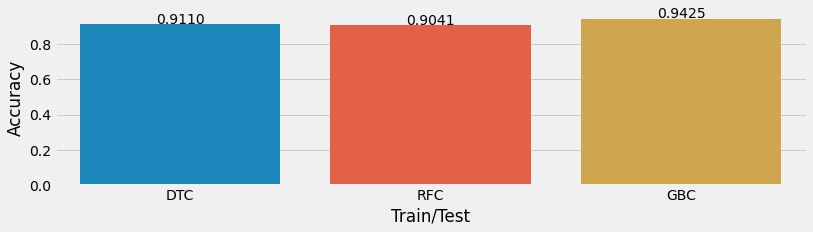

In [67]:
axis = sns.barplot(x = 'Nome', y = 'Accuracy', data = tr_split)
axis.set(xlabel='Train/Test', ylabel='Accuracy')
for p in axis.patches:
    height = p.get_height()
    axis.text(p.get_x() + p.get_width()/2, height + 0.005, '{:1.4f}'.format(height), ha="center") 
    
plt.show()

In [68]:
import numpy as np
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(model.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')

importances = pd.DataFrame({'feature':X.columns})
for name, model in models:
    t0=time.time()
    kfold = KFold(n_splits=10, random_state=10) 
    score = cross_val_score(model, X, y, cv=kfold, scoring='accuracy').mean()
    print(name)
    model.fit(X,y) 
    names.append(name)
    scores.append(score)
    
    t1 = time.time()
    total = t1-t0
    print('duracao:',total)
    importances[name] = np.round(model.feature_importances_,3)

importances = importances.set_index('feature')

DTC
duracao: 0.20648407936096191
RFC
duracao: 3.8551154136657715
GBC
duracao: 4.7287678718566895


## Variable importance

In [69]:
plt.rcParams['figure.figsize'] = [14, 8]

In [70]:
importances

,DTC,RFC,GBC
feature,,,
age,0.077,0.085,0.047
sex,0.005,0.013,0.001
dayswfreq,0.332,0.289,0.528
months,0.125,0.133,0.138
tbilled,0.104,0.145,0.085
maccess,0.062,0.097,0.012
free_use,0.026,0.017,0.033
nentries,0.069,0.086,0.015
cfreq,0.011,0.015,0.022


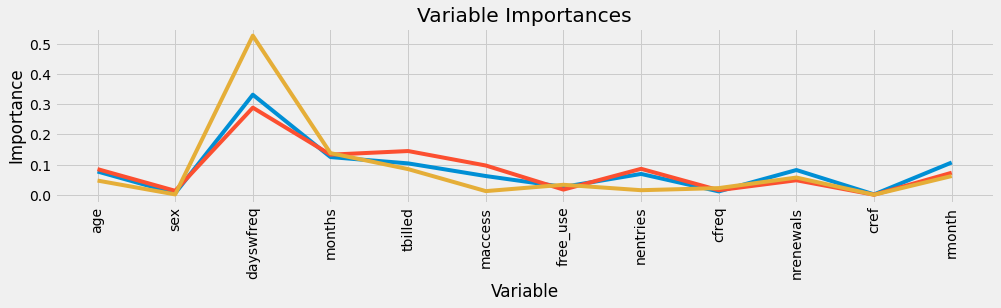

In [71]:
plt.rcParams['figure.figsize'] = [15, 3]
x_values = list(range(len(importances)))
# Make a bar chart
plt.plot(x_values, importances)
# Tick labels for x axis
plt.xticks(x_values, X_train.columns, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

### ROC Curve
Receive Operating Characteristics Curve

In [72]:
plt.rcParams['figure.figsize'] = [10, 10]

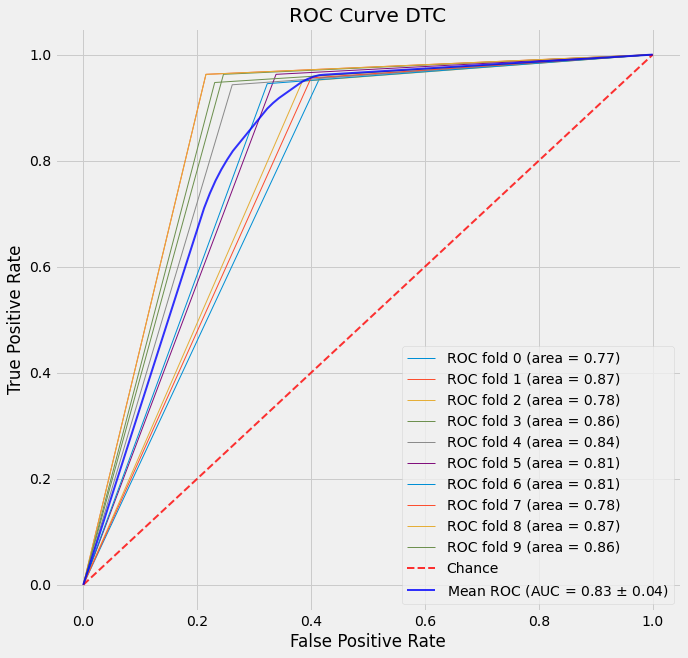

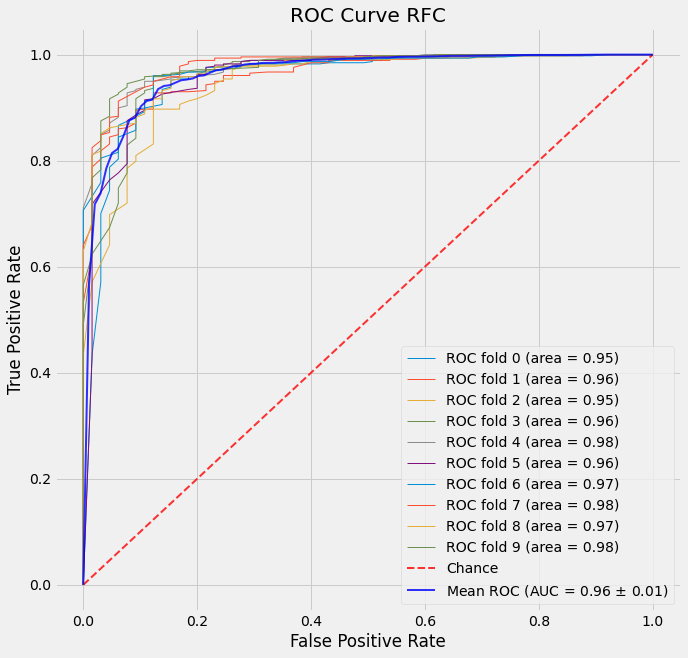

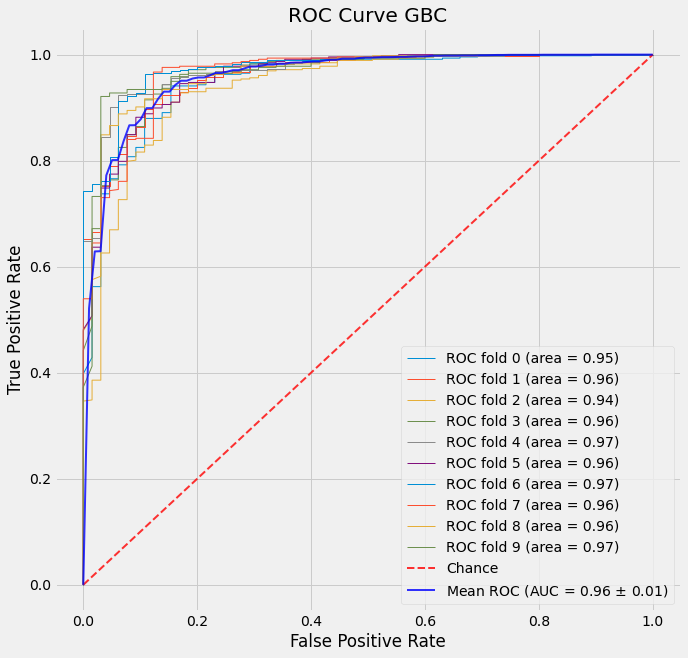

In [73]:
#Adapted from https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html#sphx-glr-auto-examples-model-selection-plot-roc-crossval-py
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from scipy import interp

mean_fpr = np.linspace(0, 1, 100)
mean_tpr = 0

for name, model in models:
    kfold = KFold(n_splits=10, random_state=10) 
    cv = StratifiedKFold(n_splits=10)
    score = cross_val_score(model, X, y, cv=kfold, scoring='accuracy').mean()
    i=0
    tprs= []
    aucs= []
    for train, test in cv.split(X, y):
        probas_ = model.fit(X.iloc[train], y.iloc[train]).predict_proba(X.iloc[test])
        probas_ = model.fit(X.iloc[train], y.iloc[train]).predict_proba(X.iloc[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y.iloc[test], probas_[:,1])
        tprs.append(interp(mean_fpr,fpr,tpr))
        tprs[-1][0] = 0.0
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
        i += 1

    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
    
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)
    
    plt.xlim([-0.05, 1.05]); plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.title('ROC Curve '+name); plt.legend(loc="lower right")
    plt.show()

# Vamos ver a importância de cada variável em cada árvore no random forest

In [74]:
importances = pd.DataFrame({'feature':X.columns})

kfold = KFold(n_splits=10, random_state=10) 
score = cross_val_score(model, X, y, cv=kfold, scoring='accuracy').mean()
model = RandomForestClassifier(n_estimators= 10, max_leaf_nodes=4)
model.fit(X,y) 

i=1
for tree in model.estimators_:
    t0=time.time()
    kfold = KFold(n_splits=10, random_state=10) 
    names.append(name)
    scores.append(score)
    
    t1 = time.time()
    total = t1-t0
    importances[i] = np.round(tree.feature_importances_,3)
    i+=1

importances = importances.set_index('feature')

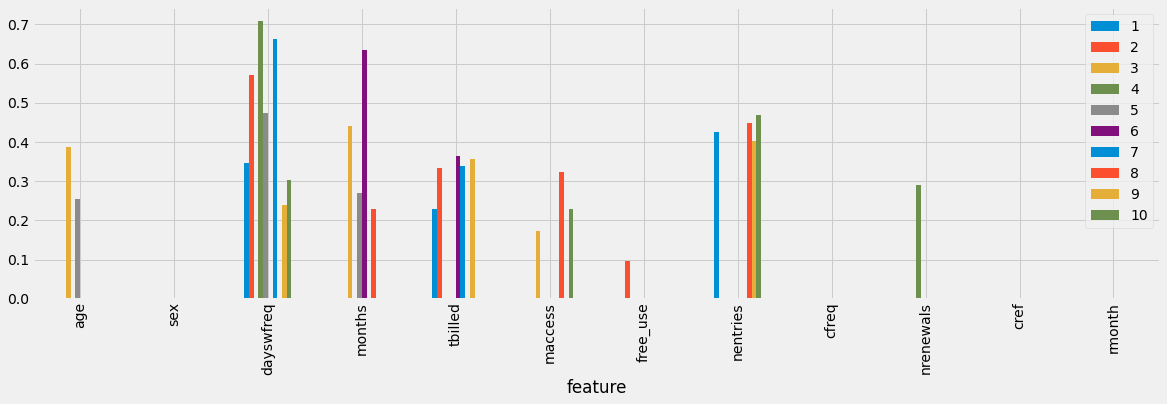

In [75]:
plt.rcParams['figure.figsize'] = [18, 5]
importances.plot.bar()
plt.xticks(rotation=90);